# Title of your Work


*Teammembers*

## Introduction:

Explain why you have chosen this topic. Why is it interesting? What makes it hard to solve?



## Idea


Explain what your idea is. Whats your approach in tackling this problem. Explain in detail the general idea, the steps and also why this should lead to a better solution


## Solution

### "Naive"/default solution

Describe how the naive solution is implemented. If the default solution already has some optimization in it, explain what it is.
And then implement the solution in code. Explain what parameters can be changed in the code below.

In [40]:
# Importing all the parts we will need.
from typing import List, Optional

from qiskit import transpile, QuantumCircuit, QuantumRegister, ClassicalRegister, Aer
from qiskit.providers.fake_provider import FakeManilaV2
from qiskit.visualization import plot_histogram, plot_gate_map
from qiskit_optimization.applications import Tsp
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from qiskit.circuit.library import TwoLocal
from qiskit.algorithms.minimum_eigensolvers import SamplingVQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.utils import algorithm_globals
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.primitives import Sampler

import warnings

warnings.filterwarnings("ignore")

import math

pi = math.pi


# Your code here: Implementation of the naive solution

In [41]:
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

def draw_tsp_solution(G, order, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(
        G2, node_color=colors, edge_color="b", node_size=600, alpha=0.8, ax=default_axes, pos=pos
    )
    edge_labels = nx.get_edge_attributes(G2, "weight")
    nx.draw_networkx_edge_labels(G2, pos, font_color="b", edge_labels=edge_labels)


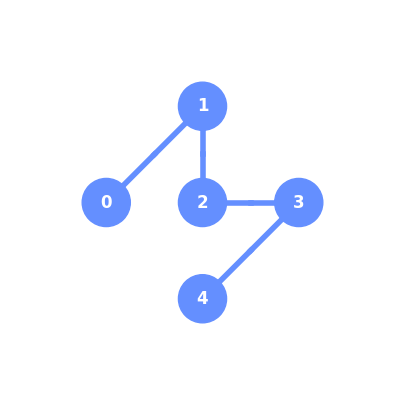

In [42]:
# print manila topology
backend_manila = FakeManilaV2()
plot_gate_map(backend_manila)

distance
 [[ 0. 48. 91.]
 [48.  0. 63.]
 [91. 63.  0.]]


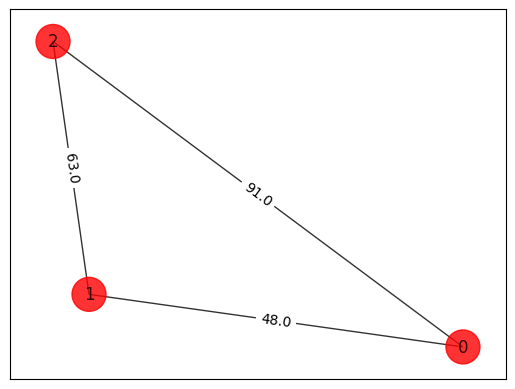

In [43]:
# Simple graph with three nodes for Traveling-Salesman-Problem (TSP) as basic introductory example
# Generating a graph of 3 nodes
n = 3
num_qubits = n**2
tsp = Tsp.create_random_instance(n, seed=123)
adj_matrix = nx.to_numpy_array(tsp.graph)
print("distance\n", adj_matrix)

colors = ["r" for node in tsp.graph.nodes]
pos = [tsp.graph.nodes[node]["pos"] for node in tsp.graph.nodes]
draw_graph(tsp.graph, colors, pos)

In [44]:
# mapping to ising model
qp = tsp.to_quadratic_program()
print(qp.prettyprint())

Problem name: TSP

Minimize
  48*x_0_0*x_1_1 + 48*x_0_0*x_1_2 + 91*x_0_0*x_2_1 + 91*x_0_0*x_2_2
  + 48*x_0_1*x_1_0 + 48*x_0_1*x_1_2 + 91*x_0_1*x_2_0 + 91*x_0_1*x_2_2
  + 48*x_0_2*x_1_0 + 48*x_0_2*x_1_1 + 91*x_0_2*x_2_0 + 91*x_0_2*x_2_1
  + 63*x_1_0*x_2_1 + 63*x_1_0*x_2_2 + 63*x_1_1*x_2_0 + 63*x_1_1*x_2_2
  + 63*x_1_2*x_2_0 + 63*x_1_2*x_2_1

Subject to
  Linear constraints (6)
    x_0_0 + x_0_1 + x_0_2 == 1  'c0'
    x_1_0 + x_1_1 + x_1_2 == 1  'c1'
    x_2_0 + x_2_1 + x_2_2 == 1  'c2'
    x_0_0 + x_1_0 + x_2_0 == 1  'c3'
    x_0_1 + x_1_1 + x_2_1 == 1  'c4'
    x_0_2 + x_1_2 + x_2_2 == 1  'c5'

  Binary variables (9)
    x_0_0 x_0_1 x_0_2 x_1_0 x_1_1 x_1_2 x_2_0 x_2_1 x_2_2



In [45]:
#convert to qubo
qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
qubitOp, offset = qubo.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: 7581.0
Ising Hamiltonian:
-1282.5 * IIIIIIIIZ
- 1282.5 * IIIIIIIZI
- 1282.5 * IIIIIIZII
- 1268.5 * IIIIIZIII
- 1268.5 * IIIIZIIII
- 1268.5 * IIIZIIIII
- 1290.0 * IIZIIIIII
- 1290.0 * IZIIIIIII
- 1290.0 * ZIIIIIIII
+ 606.5 * IIIIIIIZZ
+ 606.5 * IIIIIIZIZ
+ 606.5 * IIIIIIZZI
+ 606.5 * IIIIIZIIZ
+ 12.0 * IIIIIZIZI
+ 12.0 * IIIIIZZII
+ 12.0 * IIIIZIIIZ
+ 606.5 * IIIIZIIZI
+ 12.0 * IIIIZIZII
+ 606.5 * IIIIZZIII
+ 12.0 * IIIZIIIIZ
+ 12.0 * IIIZIIIZI
+ 606.5 * IIIZIIZII
+ 606.5 * IIIZIZIII
+ 606.5 * IIIZZIIII
+ 606.5 * IIZIIIIIZ
+ 22.75 * IIZIIIIZI
+ 22.75 * IIZIIIZII
+ 606.5 * IIZIIZIII
+ 15.75 * IIZIZIIII
+ 15.75 * IIZZIIIII
+ 22.75 * IZIIIIIIZ
+ 606.5 * IZIIIIIZI
+ 22.75 * IZIIIIZII
+ 15.75 * IZIIIZIII
+ 606.5 * IZIIZIIII
+ 15.75 * IZIZIIIII
+ 606.5 * IZZIIIIII
+ 22.75 * ZIIIIIIIZ
+ 22.75 * ZIIIIIIZI
+ 606.5 * ZIIIIIZII
+ 15.75 * ZIIIIZIII
+ 15.75 * ZIIIZIIII
+ 606.5 * ZIIZIIIII
+ 606.5 * ZIZIIIIII
+ 606.5 * ZZIIIIIII


In [46]:
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qubo)
print(result.prettyprint())

objective function value: 202.0
variable values: x_0_0=1.0, x_0_1=0.0, x_0_2=0.0, x_1_0=0.0, x_1_1=1.0, x_1_2=0.0, x_2_0=0.0, x_2_1=0.0, x_2_2=1.0
status: SUCCESS


energy: -7326.02469952182
time: 16.45866322517395
feasible: True
solution: [1, 2, 0]
solution objective: 202.0


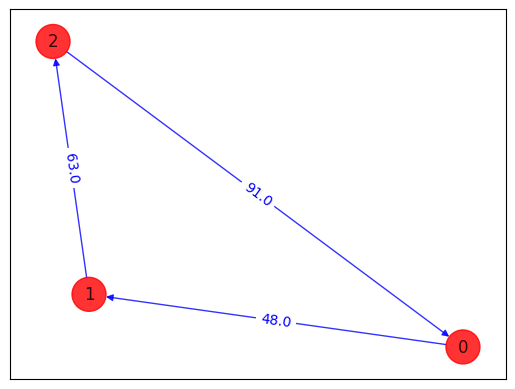

In [47]:
# run on quantum computers
algorithm_globals.random_seed = 123
seed = 10598

optimizer = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=5, entanglement="linear")
vqe = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=optimizer)

result = vqe.compute_minimum_eigenvalue(qubitOp)

print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
x = tsp.sample_most_likely(result.eigenstate)
print("feasible:", qubo.is_feasible(x))
z = tsp.interpret(x)
print("solution:", z)
print("solution objective:", tsp.tsp_value(z, adj_matrix))
draw_tsp_solution(tsp.graph, z, colors, pos)

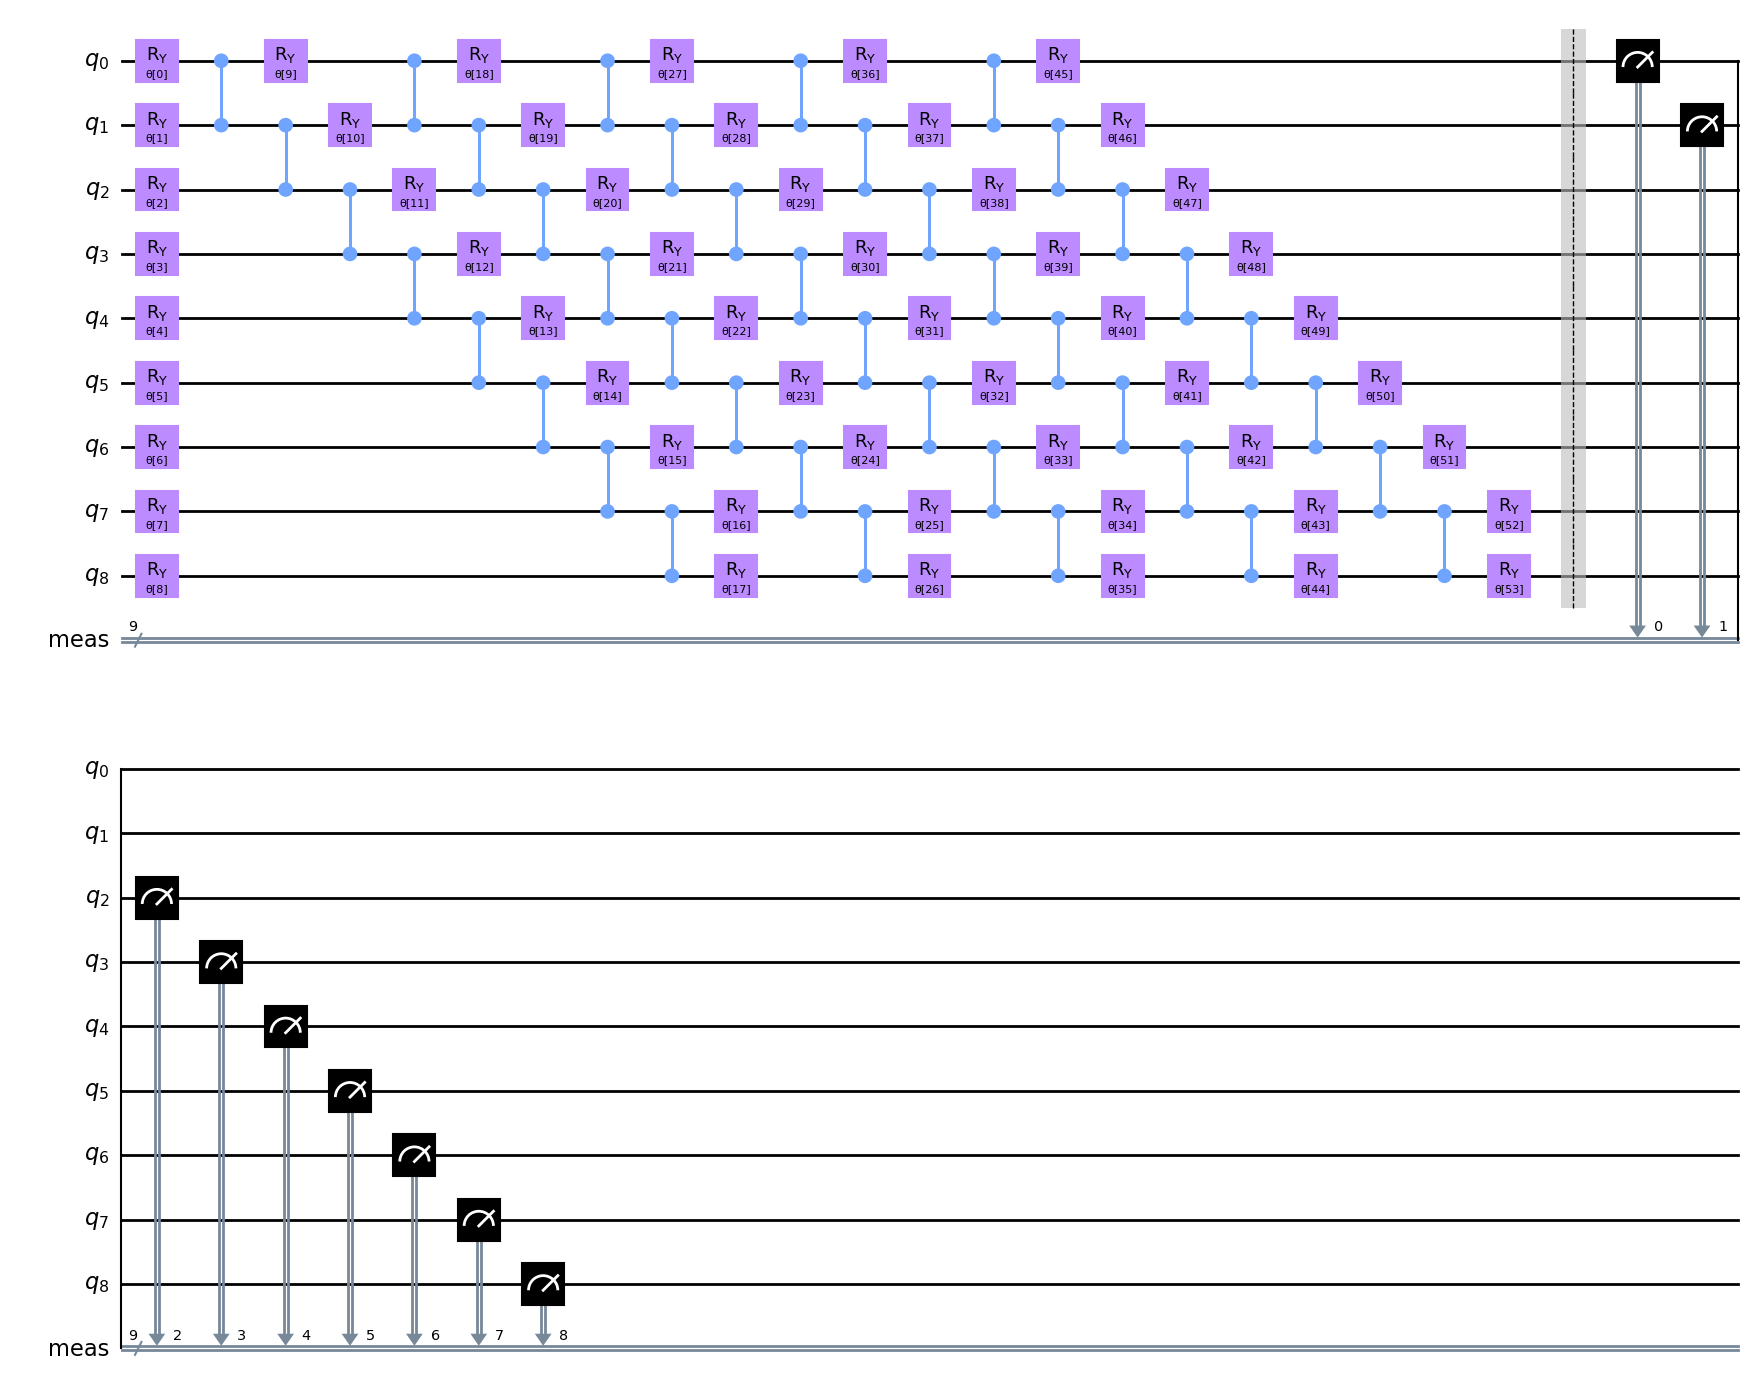

In [48]:
#print our ansatz
ry.decompose().draw('mpl')

objective function value: 202.0
variable values: x_0_0=0.0, x_0_1=1.0, x_0_2=0.0, x_1_0=0.0, x_1_1=0.0, x_1_2=1.0, x_2_0=1.0, x_2_1=0.0, x_2_2=0.0
status: SUCCESS
solution: [1, 2, 0]
solution objective: 202.0


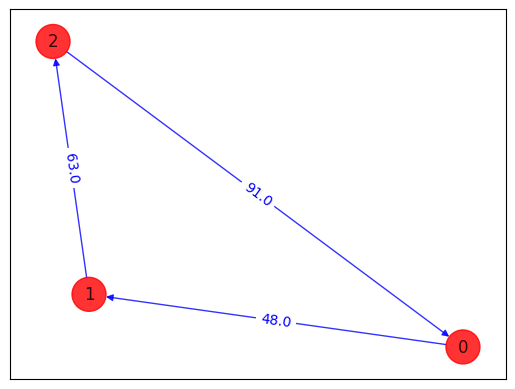

In [49]:
# create minimum eigen optimizer based on SamplingVQE
vqe_optimizer = MinimumEigenOptimizer(vqe)

# solve quadratic program
result = vqe_optimizer.solve(qp)
print(result.prettyprint())

z = tsp.interpret(x)
print("solution:", z)
print("solution objective:", tsp.tsp_value(z, adj_matrix))
draw_tsp_solution(tsp.graph, z, colors, pos)

# define qoaoa (reference Prof. Dr. Gerhard Hellstern, HPI)
Starte mit einem parametrisierten Ansatz $| \Psi (\alpha, \beta, \gamma ...) \rangle$ und variere die Parameter so lange, bis das Minimum erreicht ist. Das ist die allg. Idee der sog. "Variationellen Quantenalgorithmen (VQA)".

* QAOA ist ein Spezialfall davon; hier macht man keinen möglichst allgemeinen Ansatz (mit vielen Parametern ...), sondern lässt sich beim Ansatz durch die Physik inspirieren:

* Motiviert durch das "Adiabatentheorem" (ein System bei dem man Änderungen nur langsam genug vornimmt bleibt immer in seinem Grundzustand) wird schliesslich bei QAOA folgender Ansatz gemacht:

$$ H_{final} = \alpha H_{mixer} + \beta H_{Ising}$$ mit $$ H_{mixer}=\sum_i {\hat\sigma_{x}^{(i)}}$$

In [50]:
# convert qp to hamiltonian
conv = QuadraticProgramToQubo()
qp2 = conv.convert(qp)
op,offset=op, offset = qp2.to_ising()
print("Constant:",offset)
print("Matrix:",op)

Constant: 7581.0
Matrix: -1282.5 * IIIIIIIIZ
- 1282.5 * IIIIIIIZI
- 1282.5 * IIIIIIZII
- 1268.5 * IIIIIZIII
- 1268.5 * IIIIZIIII
- 1268.5 * IIIZIIIII
- 1290.0 * IIZIIIIII
- 1290.0 * IZIIIIIII
- 1290.0 * ZIIIIIIII
+ 606.5 * IIIIIIIZZ
+ 606.5 * IIIIIIZIZ
+ 606.5 * IIIIIIZZI
+ 606.5 * IIIIIZIIZ
+ 12.0 * IIIIIZIZI
+ 12.0 * IIIIIZZII
+ 12.0 * IIIIZIIIZ
+ 606.5 * IIIIZIIZI
+ 12.0 * IIIIZIZII
+ 606.5 * IIIIZZIII
+ 12.0 * IIIZIIIIZ
+ 12.0 * IIIZIIIZI
+ 606.5 * IIIZIIZII
+ 606.5 * IIIZIZIII
+ 606.5 * IIIZZIIII
+ 606.5 * IIZIIIIIZ
+ 22.75 * IIZIIIIZI
+ 22.75 * IIZIIIZII
+ 606.5 * IIZIIZIII
+ 15.75 * IIZIZIIII
+ 15.75 * IIZZIIIII
+ 22.75 * IZIIIIIIZ
+ 606.5 * IZIIIIIZI
+ 22.75 * IZIIIIZII
+ 15.75 * IZIIIZIII
+ 606.5 * IZIIZIIII
+ 15.75 * IZIZIIIII
+ 606.5 * IZZIIIIII
+ 22.75 * ZIIIIIIIZ
+ 22.75 * ZIIIIIIZI
+ 606.5 * ZIIIIIZII
+ 15.75 * ZIIIIZIII
+ 15.75 * ZIIIZIIII
+ 606.5 * ZIIZIIIII
+ 606.5 * ZIZIIIIII
+ 606.5 * ZZIIIIIII


In [55]:
def print_result(result):
    selection = result.x
    value = result.fval
    print('Optimal: selection {}, value {:.4f}'.format(selection, value))

In [56]:
#solve qoaoa
from qiskit.utils import QuantumInstance
from qiskit.algorithms.optimizers import COBYLA
from qiskit.algorithms import QAOA
algorithm_globals.random_seed = 1234
backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend=backend, seed_simulator=123, seed_transpiler=123)

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
qaoa_mes = QAOA(optimizer=cobyla, reps=1, quantum_instance=quantum_instance)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result_sv = qaoa.solve(qp2)

print(result_sv)
print_result(result_sv)

fval=202.0, x_0_0=0.0, x_0_1=0.0, x_0_2=1.0, x_1_0=0.0, x_1_1=1.0, x_1_2=0.0, x_2_0=1.0, x_2_1=0.0, x_2_2=0.0, status=SUCCESS
Optimal: selection [0. 0. 1. 0. 1. 0. 1. 0. 0.], value 202.0000


### Your solution

Explain which paramateres can be changed in the code below, how to get different results.

In [ ]:

# Your code here: Implementation of the good solution

## Results

Analyse both solutions the naive and yours, and show what is better.
This can both be done theoretically (like Big O notation) or also some concrete results.
If possible show below some graphs to compare the 2 solutions helping to explain what makes your solution so good.

In [ ]:

# Your code here: Use code to show graphs